# Padded 1D Column Max Signals

Processes cluster data to create standardized 1D signals from column maxes. Pads variable-length cluster projections to a fixed 240-wire length based on their spatial position in the detector.

**Purpose:** Creates uniform input data for machine learning models from variable-sized particle clusters.

Uses data created in **clusters_data.ipynb**



In [1]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [2]:
# Threshold = 15, all connected regions. 
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl")
protonsdf = pd.read_pickle('/Users/user/data/research/proton-deuteron/csv/protonclusters.pkl')
deuteronsdf = pd.read_pickle('/Users/user/data/research/proton-deuteron/csv/deuteronclusters.pkl')

# Cleaning

- length over 10 wires.

In [3]:
print(allclusters.shape)
allclusters = allclusters[allclusters['column_maxes'].map(len) > 15].reset_index(drop=True); print(allclusters.shape)

(438575, 27)
(64032, 27)


In [4]:
allclusters.describe()

,event_idx,run,subrun,event,event_index,cluster_idx,area,max_intensity,min_intensity,mean_intensity,...,centroid_x,centroid_y,bbox_min_row,bbox_min_col,bbox_max_row,bbox_max_col,width,height,aspect_ratio,compactness
count,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,...,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000,64032.000000
mean,3577.105229,9155.966033,181.327149,15776.253514,0.206287,12.597420,4165.906781,266.628295,16.000016,64.068248,...,95.777432,1360.838896,49.285342,1244.398316,142.420290,1488.041261,243.642944,93.134948,3.616466,0.239019
std,2068.514591,436.020473,132.915193,11921.915423,0.477740,32.242795,5230.251161,196.521940,0.003952,30.094606,...,50.007122,744.891517,50.611751,758.176836,67.427226,742.371500,207.771899,65.367028,3.601370,0.135304
min,0.000000,8557.000000,1.000000,11.000000,0.000000,0.000000,24.000000,20.000000,16.000000,16.883212,...,3.597895,1.048780,0.000000,0.000000,16.000000,4.000000,3.000000,16.000000,0.147826,0.016106
25%,1777.000000,8680.000000,67.000000,5734.750000,0.000000,0.000000,1306.000000,124.000000,16.000000,39.429672,...,51.752071,873.963191,19.000000,740.000000,77.000000,1024.000000,117.000000,36.000000,1.543590,0.134840
50%,3554.000000,9451.000000,155.000000,13271.000000,0.000000,2.000000,2684.000000,225.000000,16.000000,56.502722,...,91.367018,1210.332662,28.000000,1113.000000,141.000000,1328.000000,190.000000,71.000000,2.687500,0.210174
75%,5360.000000,9509.000000,278.000000,23423.000000,0.000000,10.000000,4975.000000,354.000000,16.000000,81.949376,...,128.317181,1771.515065,52.000000,1664.000000,210.000000,1904.000000,302.000000,155.000000,4.465615,0.318691
max,7635.000000,9788.000000,624.000000,52920.000000,5.000000,507.000000,184515.000000,2354.000000,17.000000,312.279639,...,232.466587,3070.625000,224.000000,3069.000000,240.000000,3072.000000,3072.000000,240.000000,101.062500,0.893832


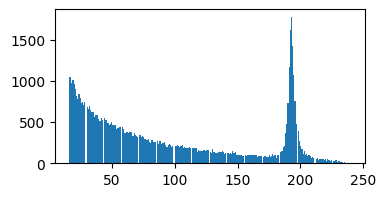

In [5]:
plt.figure(figsize=(4,2)); plt.hist(allclusters['column_maxes'].apply(len), bins=240); plt.show()

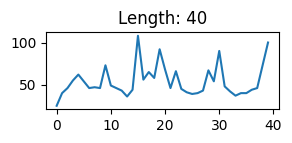

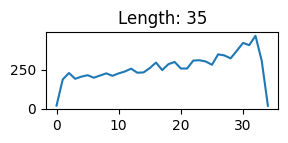

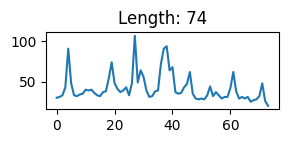

In [6]:
sample = allclusters['column_maxes'].sample(3)

for i, sample in enumerate(sample):
    plt.figure(figsize=(3,1)); plt.plot(sample); plt.title(f"Length: {len(sample)}") 

In [7]:
# TODO: could a simple cut on how much ADC changes work.

# Padding function for 'column_maxes'

In [8]:
def padding(column_maxes, min, max, target=240):
    
    signal = np.array(column_maxes); length = len(signal)
    zeros = np.zeros(target)
    span = max - min + 1
    
    if length != span:
        if abs(length - span) > 2:
            print(f"Length {length} != Span {span}")
    
    start = min
    end = min + length

    zeros[start:end] = signal[0:length]
    
    padded = zeros

    return padded

In [9]:
data = [] # all data

for idx, row in allclusters.iterrows():
    padded_signal = padding(
        row['column_maxes'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    data.append(padded_signal)

data = np.array(data)

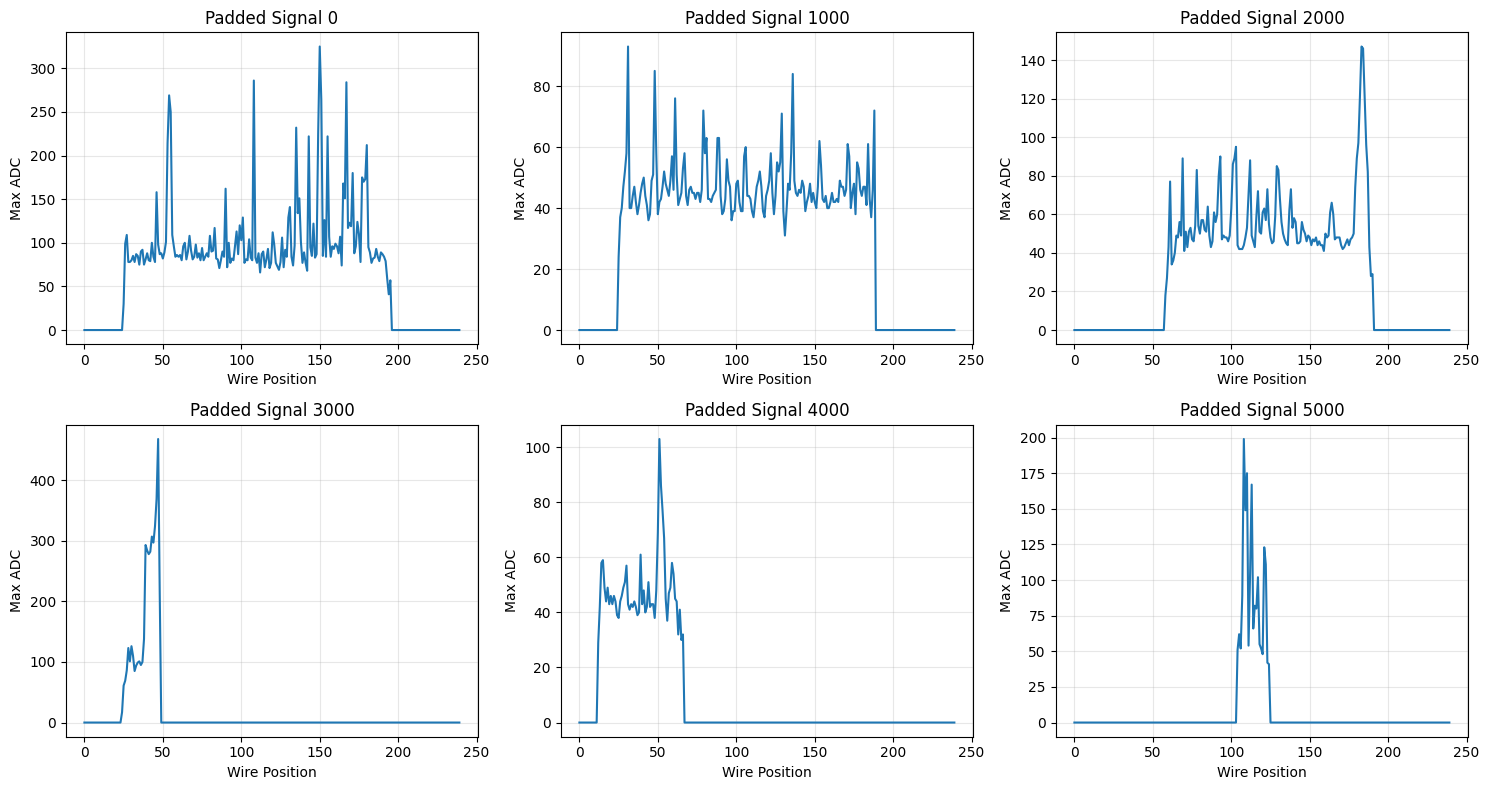

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    signal = data[i * 1000]
    ax.plot(signal)
    ax.set_title(f'Padded Signal {i * 1000}')
    ax.set_xlabel('Wire Position')
    ax.set_ylabel('Max ADC')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
data

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [60., 91., 85., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
# np.save('padded_max_adc_columns.npy', data)

In [13]:
print(protonsdf.shape); protonsdf = protonsdf[protonsdf['column_maxes'].map(len) > 10].reset_index(drop=True); print(protonsdf.shape)
print(deuteronsdf.shape); deuteronsdf = deuteronsdf[deuteronsdf['column_maxes'].map(len) > 10].reset_index(drop=True); print(deuteronsdf.shape)

(83696, 27)
(16097, 27)
(354879, 27)
(54825, 27)


In [14]:
# protons only

protons = [] # all data

for idx, row in protonsdf.iterrows():
    padded_signal = padding(
        row['column_maxes'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    protons.append(padded_signal)

protons = np.array(protons)

# np.save('/Users/user/data/research/proton-deuteron/csv/padded_protons.npy', protons)

In [15]:
# deuterons only

deuterons = [] # all data

for idx, row in deuteronsdf.iterrows():
    padded_signal = padding(
        row['column_maxes'],
        row['bbox_min_row'],
        row['bbox_max_row']
    )
    deuterons.append(padded_signal)

deuterons = np.array(deuterons)

# np.save('/Users/user/data/research/proton-deuteron/csv/padded_deuterons.npy', deuterons)

Smoothing data for better clustering?

In [16]:
allclusters

,event_idx,run,subrun,event,file_path,event_index,particle_type,plane,cluster_idx,area,...,bbox_min_col,bbox_max_row,bbox_max_col,width,height,aspect_ratio,compactness,image_intensity,matrix_transformed,column_maxes
0,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,9047.0,...,154,196,944,790,171,4.619883,0.066970,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0...","[30.0, 99.0, 109.0, 78.0, 78.0, 80.0, 85.0, 78..."
1,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,induction,0,4030.0,...,156,169,873,717,148,4.844595,0.037977,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[17.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[20.0, 78.0, 66.0, 55.0, 47.0, 43.0, 47.0, 48...."
2,1,8682,479,43081,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,2346.0,...,553,47,699,146,47,3.106383,0.341883,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 16.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0...","[60.0, 91.0, 85.0, 87.0, 98.0, 94.0, 106.0, 88..."
3,1,8682,479,43081,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,1,11874.0,...,221,215,499,278,194,1.432990,0.220166,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[36.0, 78.0, 68.0, 66.0, 69.0, 62.0, 74.0, 79...."
4,1,8682,479,43081,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,2,10122.0,...,1561,220,1825,264,193,1.367876,0.198658,"[[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0...","[[-0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0....","[43.0, 53.0, 77.0, 133.0, 66.0, 70.0, 72.0, 71..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64027,7633,9788,305,26707,/Users/user/data/research/proton-deuteron/rawp...,0,proton,induction,0,534.0,...,870,33,962,92,20,4.600000,0.290217,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[19.0, 60.0, 70.0, 51.0, 52.0, 54.0, 52.0, 52...."
64028,7634,9788,308,26943,/Users/user/data/research/proton-deuteron/rawp...,0,proton,collection,0,2692.0,...,906,71,1052,146,45,3.244444,0.409741,"[[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[17.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0...","[55.0, 81.0, 87.0, 144.0, 131.0, 120.0, 122.0,..."
64029,7634,9788,308,26943,/Users/user/data/research/proton-deuteron/rawp...,0,proton,induction,0,1359.0,...,891,66,997,106,47,2.255319,0.272782,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[17.0, 50.0, 67.0, 77.0, 68.0, 65.0, 67.0, 73...."
64030,7635,9788,311,27225,/Users/user/data/research/proton-deuteron/rawp...,0,proton,collection,1,3298.0,...,1117,77,1284,167,58,2.879310,0.340491,"[[-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0,...","[[17.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0...","[32.0, 50.0, 79.0, 76.0, 90.0, 89.0, 98.0, 87...."


In [17]:
signals = allclusters['column_maxes']

Simple Moving Average

In [18]:
window_size = 10

kernel = np.ones(window_size) / window_size

smoothed_signals = [
    np.convolve(row, kernel, mode='same')  # or 'valid'
    for row in signals
]

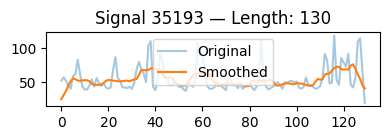

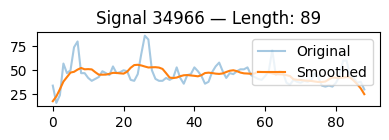

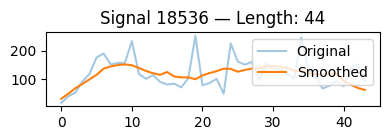

In [19]:
import random

indices = random.sample(range(len(signals)), 3)

# Plot original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  # faint
    plt.plot(smoothed, label='Smoothed')            # bold
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Savgol filter - fits polynomials to local windows of data

In [20]:
from scipy.signal import savgol_filter

smoothed_signals = [
    savgol_filter(row, window_length=16, polyorder=3)  
    for row in signals
]

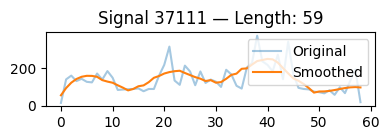

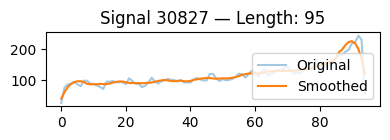

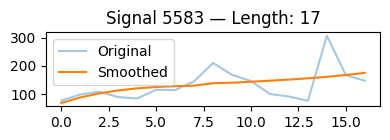

In [21]:
indices = random.sample(range(len(signals)), 3)

# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')           
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
from scipy.ndimage import gaussian_filter1d

smoothed_signals = [
    gaussian_filter1d(row, sigma=1.5)  
    for row in signals
]

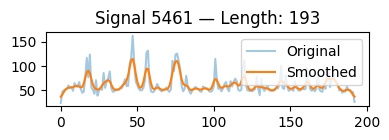

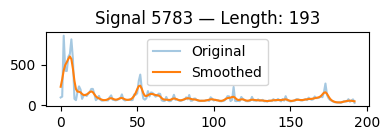

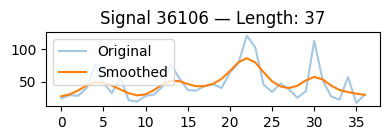

In [23]:
indices = random.sample(range(len(signals)), 3)

# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')           
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

Median filter - replace values with median in the window

In [24]:
from scipy.signal import medfilt

smoothed_signals = [
    medfilt(row, kernel_size=3)  
    for row in signals
]

smoothed_signals = [
    savgol_filter(row, window_length=10, polyorder=3)  
    for row in smoothed_signals
]

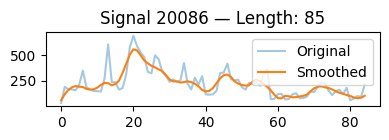

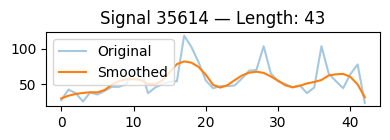

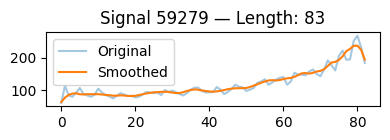

In [25]:
indices = random.sample(range(len(signals)), 3)

# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')           
    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
from scipy.interpolate import interp1d

def resample_signal(signal, target_length):
    x_original = np.linspace(0, 1, len(signal))
    x_target = np.linspace(0, 1, target_length)
    interpolator = interp1d(x_original, signal, kind='cubic') 
    return interpolator(x_target)

target_length = 64

resampled_signals = [resample_signal(sig, target_length) for sig in signals]
resampled_smoothed = [resample_signal(sig, target_length) for sig in smoothed_signals]

In [27]:
indices = random.sample(range(len(signals)), 3)

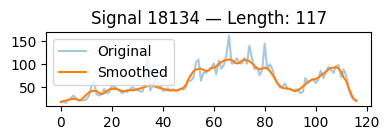

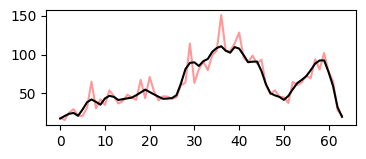

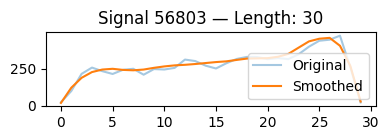

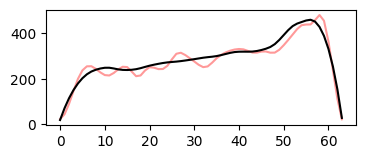

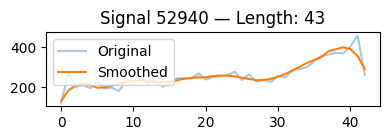

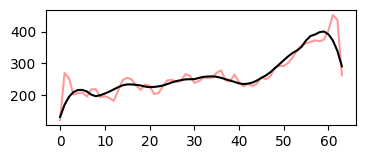

In [28]:
# Original (faint) and smoothed (bold) together
for i, idx in enumerate(indices):
    original = signals[idx]
    smoothed = smoothed_signals[idx]
    rsignal = resampled_signals[idx]
    rsmoothed = resampled_smoothed[idx]

    plt.figure(figsize=(4, 1.5))
    plt.plot(original, alpha=0.4, label='Original')  
    plt.plot(smoothed, label='Smoothed')

    plt.title(f"Signal {idx} — Length: {len(original)}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4, 1.5))
    plt.plot(rsignal, c='red', alpha=0.4)
    plt.plot(rsmoothed, c='black')
    plt.show()   

Use these 64 length, smoothed functions (using Savgol Filter), test clustering, then label clusters manually, and use to classify events for signal events, background events (events with no protons/deuterons)

# Simple cut on ADC fluctuation
To cluster signal v. noise.

In [29]:
maxes = allclusters['column_maxes'].values

adcdiff = []

for i in maxes:
    cluster = []
    for j in range(len(i) - 1):
        entry = i[j+1] - i[j]
        cluster.append(entry)
    adcdiff.append(cluster)

In [30]:
maxes = allclusters['column_maxes'].values
adcdiff = [np.diff(signal) for signal in maxes]

In [31]:
bigdiff = [max(signal) for signal in adcdiff]

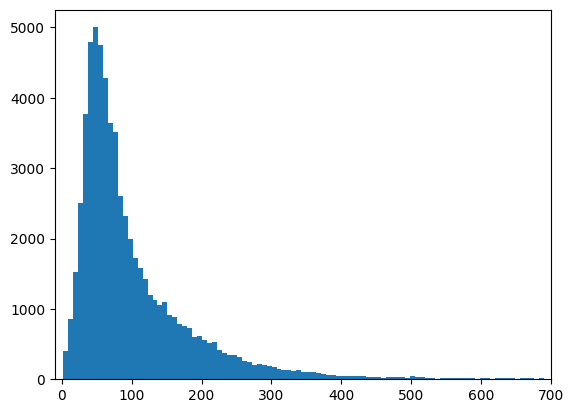

In [32]:
plt.figure()
plt.hist(bigdiff, bins=300)
plt.xlim(-10, 700)
plt.show()

Using normalised data. 

In [33]:
# TODO: Is doing difference between i and i+1 wire best way to characterise sudden large ADC changes? 
# TODO: column_maxes best? 

In [ ]:
maxes = allclusters['column_maxes'].values

nmaxes = []

for signal in maxes:
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val > min_val:
        normalized_signal = (signal - min_val) / (max_val - min_val)
    else:
        normalized_signal = np.zeros_like(signal, dtype=float)
        print('a problem?')
    nmaxes.append(normalized_signal)

nadcdiff = [np.diff(signal) for signal in nmaxes] # all changes + / -
nmaxdiff = [max(signal) for signal in nadcdiff]   # biggest positive change in ADC in each event

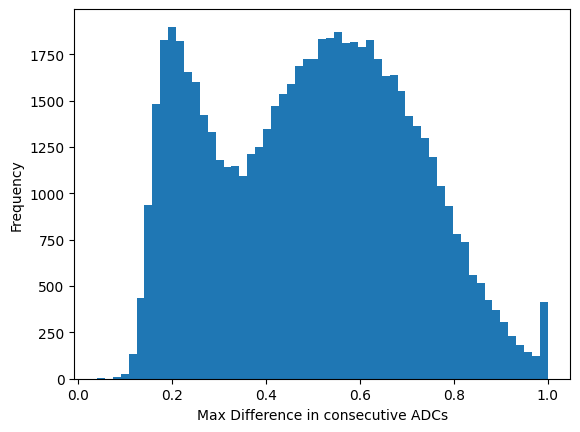

In [35]:
plt.figure()
plt.hist(nmaxdiff, bins='auto')
plt.xlabel('Max Difference in consecutive ADCs')
plt.ylabel('Frequency')
plt.show()

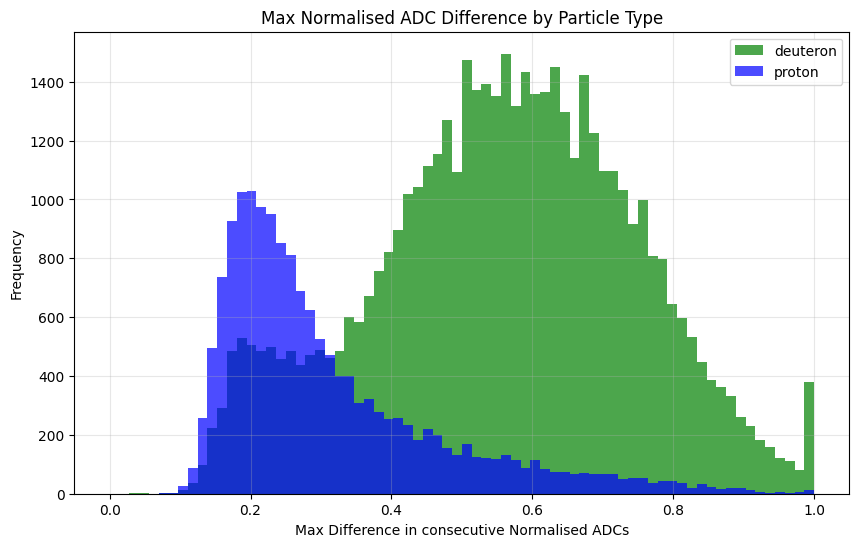

In [36]:
nmaxdiff = np.array(nmaxdiff)
particle_types = allclusters['particle_type'].values
unique_particles = allclusters['particle_type'].unique()

colors = {
    'proton': 'blue', 
    'deuteron': 'green'
}

plt.figure(figsize=(10, 6))

protons = []
deuterons = []

for p_type in unique_particles:
    mask = (particle_types == p_type)
    
    change = nmaxdiff[mask]

    if p_type == 'proton':
        protons = change
    else:
        deuterons = change


    plt.hist(change, 
             bins='auto',
             range=(0, 1), 
             alpha=0.7, 
             label=p_type, 
             color=colors.get(p_type, 'purple')) 

plt.title('Max Normalised ADC Difference by Particle Type')
plt.xlabel('Max Difference in consecutive Normalised ADCs')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
clean = np.where(nmaxdiff <= 0.26)[0]

Plotting 1 random 'clean' signals...


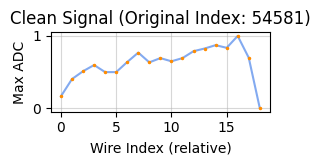

In [38]:
num_samples = 1

if len(clean) >= num_samples:
    sampled_indices = random.sample(list(clean), num_samples)

    print(f"Plotting {num_samples} random 'clean' signals...")
    for idx in sampled_indices:
        signal = nmaxes[idx]
        
        plt.figure(figsize=(3, 1.75))
        plt.plot(signal, color='cornflowerblue', alpha=0.8)
        plt.plot(signal, 'o', color='darkorange', markersize=1.5)
        plt.title(f"Clean Signal (Original Index: {idx})")
        plt.xlabel("Wire Index (relative)")
        plt.ylabel("Max ADC")
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()
else:
    print(f"Not enough clean signals to sample {num_samples}. Only {len(clean)} available.")

In [39]:
len(clean), clean

(11948, array([   46,    49,    56, ..., 64029, 64030, 64031]))

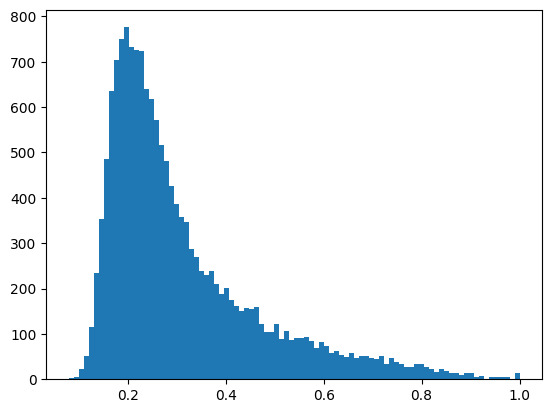

In [40]:
plt.hist(protons, bins=90)
plt.show()

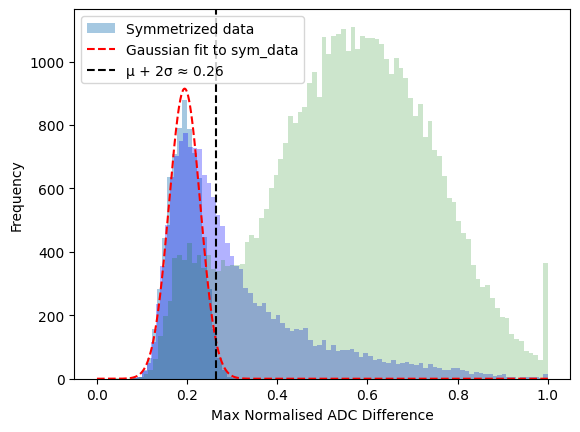

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

counts, bin_edges = np.histogram(protons, bins=90, range=(0, 1))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
peak_index = np.argmax(counts)
peak_x = bin_centers[peak_index]

left_half = protons[protons < peak_x]

mirrored = 2 * peak_x - left_half
sym_data = np.concatenate([left_half, mirrored])

mu_sym, sigma_sym = norm.fit(sym_data)

x = np.linspace(0, 1, 1000)
bin_width = (bin_edges[1] - bin_edges[0])
pdf_fit = norm.pdf(x, mu_sym, sigma_sym) * len(sym_data) * bin_width

# Plot
plt.hist(sym_data, bins=90, range=(0, 1), alpha=0.4, label='Symmetrized data')
plt.hist(protons, bins=90, color='blue', alpha=0.3)
plt.hist(deuterons, bins=90, color='green', alpha=0.2)
plt.plot(x, pdf_fit, 'r--', label='Gaussian fit to sym_data')
plt.axvline(mu_sym + 2 * sigma_sym, color='black', linestyle='--', label=f'μ + 2σ ≈ {mu_sym + 2*sigma_sym:.2f}')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Clean deuterons

In [42]:
deuteronmaxes = deuteronsdf['column_maxes'].values

deuteronnmaxes = []

for signal in deuteronmaxes:
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val > min_val:
        normalized_signal = (signal - min_val) / (max_val - min_val)
    else:
        normalized_signal = np.zeros_like(signal, dtype=float)
        print('yo is there a problem?')
    deuteronnmaxes.append(normalized_signal)

deuteronnadcdiff = [np.diff(signal) for signal in deuteronnmaxes] # all changes + / -
deuteronnmaxdiff = [max(signal) for signal in deuteronnadcdiff]   # biggest positive change in ADC in each event

In [43]:
len(deuteronnadcdiff)

54825

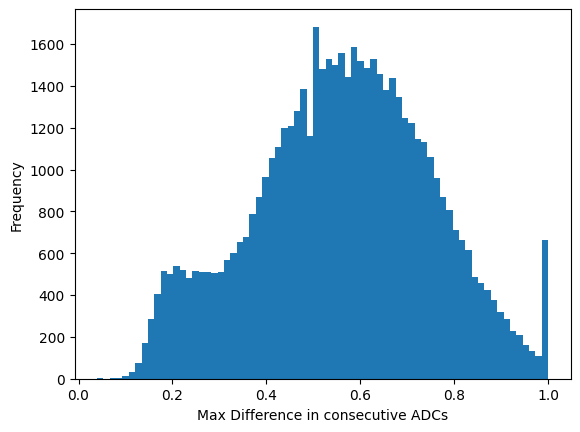

In [44]:
plt.figure()
plt.hist(deuteronnmaxdiff, bins='auto')
plt.xlabel('Max Difference in consecutive ADCs')
plt.ylabel('Frequency')
plt.show()

In [45]:
deuteronnmaxdiff = np.array(deuteronnmaxdiff)
deuteronclean = np.where(deuteronnmaxdiff <= 0.26)[0]

Plotting 1 random 'clean' signals...


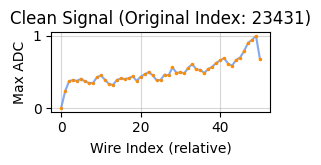

In [46]:
num_samples = 1

if len(deuteronclean) >= num_samples:

    sampled_indices = random.sample(list(deuteronclean), num_samples)

    print(f"Plotting {num_samples} random 'clean' signals...")
    for idx in sampled_indices:
        signal = deuteronnmaxes[idx]
        
        plt.figure(figsize=(3, 1.75))
        plt.plot(signal, color='cornflowerblue', alpha=0.8)
        plt.plot(signal, 'o', color='darkorange', markersize=1.5)
        plt.title(f"Clean Signal (Original Index: {idx})")
        plt.xlabel("Wire Index (relative)")
        plt.ylabel("Max ADC")
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()
else:
    print(f"Not enough clean signals to sample {num_samples}. Only {len(deuteronclean)} available.")

In [47]:
cleandeuteronsdf = deuteronsdf.iloc[deuteronclean]

In [48]:
collection_plane_df = cleandeuteronsdf[cleandeuteronsdf['plane'] == 'collection']
induction_plane_df = cleandeuteronsdf[cleandeuteronsdf['plane'] == 'induction']

In [49]:
id = cleandeuteronsdf[['run', 'subrun', 'event']]
id = id.drop_duplicates().reset_index(drop=True)
id.head(3)
id

,run,subrun,event
0,9566,93,8335
1,9541,52,3741
2,8744,154,15031
3,8648,80,6615
4,8613,70,5203
...,...,...,...
2823,9493,115,8574
2824,9508,144,14602
2825,8667,276,21860
2826,8611,49,3372


In [50]:
idfull = cleandeuteronsdf.drop_duplicates(['run', 'subrun', 'event'])

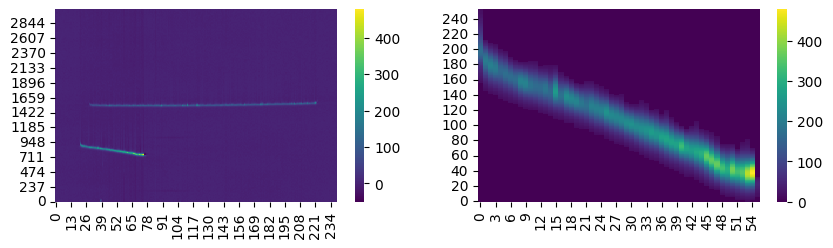

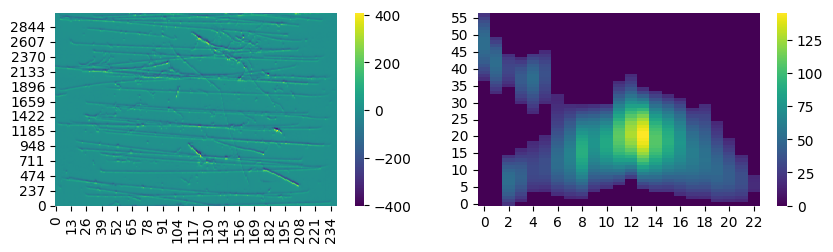

In [51]:
samples = np.random.randint(0, 2828, size=2)

for i in samples:
    event = Event(idfull['file_path'].iloc[i], plot=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    
    if idfull['plane'].iloc[i] == 'collection':
        sns.heatmap(event.collection.T, cmap="viridis",  ax=ax1)
    else:
        sns.heatmap(event.induction.T, cmap="viridis",  ax=ax1)
    ax1.invert_yaxis()

    sns.heatmap(idfull['image_intensity'].iloc[i].T, cmap="viridis", ax=ax2)
    ax2.invert_yaxis()
    plt.show()

Cleaning overlapping events - they show sudden dip in ADC

In [52]:
split_events = []
for idx, diff in enumerate(deuteronnadcdiff):
    for i in range(5, len(diff) - 5):
        if diff[i] < -0.4:
            signal = deuteronnmaxes[idx]
            array1 = signal[:i + 1]
            array2 = signal[i + 1:]
            
            split_events.append({
                "index": idx,
                "split_point": i,
                "array1": array1,
                "array2": array2
            })
            break  

print(f"Found {len(split_events)} events with large negative decreases.")

Found 33169 events with large negative decreases.


In [53]:
split_indices = [event["index"] for event in split_events]

deuteroncleaner = np.where((np.array(deuteronnmaxdiff) <= 0.26) & 
                          (np.isin(np.arange(len(deuteronnmaxdiff)), split_indices)))[0]

print(f"Found {len(deuteroncleaner)} events that are both clean (≤ 0.26) and have splits.")

Found 157 events that are both clean (≤ 0.26) and have splits.


In [54]:
# # Plot the original signals for the events in deuteroncleaner
# for event in split_events:
#     idx = event["index"]  # Get the index of the event
    
#     # Only plot if the index is in deuteroncleaner
#     if idx in deuteroncleaner:
#         signal = deuteronnmaxes[idx]  # Retrieve the original signal

#         plt.figure(figsize=(6, 2))
#         plt.plot(signal, color='cornflowerblue', alpha=0.8, label='Original Signal')
#         plt.axvline(event["split_point"], color='red', linestyle='--', label='Split Point')
#         plt.title(f"Event Index: {idx}, Split Point: {event['split_point']}")
#         plt.xlabel("Wire Index (relative)")
#         plt.ylabel("Normalized ADC")
#         plt.legend()
#         plt.grid(True, alpha=0.5)
#         plt.tight_layout()
#         plt.show()

In [55]:
finaldeuterons = np.setdiff1d(deuteronclean, deuteroncleaner)

In [56]:
cleanerdeuteronsdf = deuteronsdf.iloc[finaldeuterons]

In [57]:
cleaner_collection_plane_df = cleanerdeuteronsdf[cleanerdeuteronsdf['plane'] == 'collection']
cleaner_induction_plane_df = cleanerdeuteronsdf[cleanerdeuteronsdf['plane'] == 'induction']

In [58]:
cleanid = cleanerdeuteronsdf[['run', 'subrun', 'event']]
cleanid = cleanid.drop_duplicates().reset_index(drop=True)
cleanid

,run,subrun,event
0,9566,93,8335
1,9541,52,3741
2,8744,154,15031
3,8648,80,6615
4,8613,70,5203
...,...,...,...
2733,9493,115,8574
2734,9508,144,14602
2735,8667,276,21860
2736,8611,49,3372


In [59]:
cleanidfull = cleanerdeuteronsdf.drop_duplicates(['run', 'subrun', 'event'])

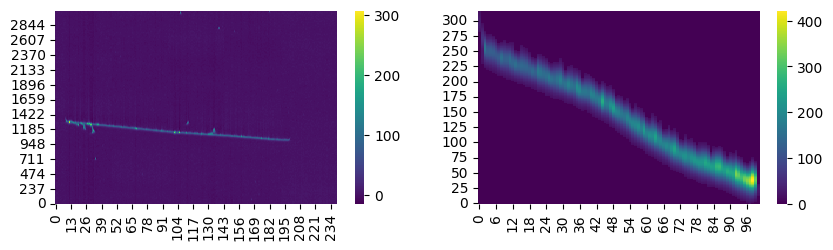

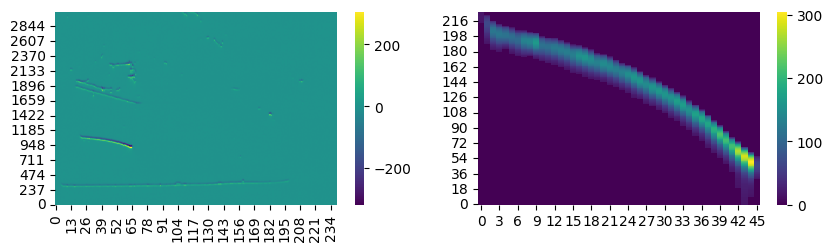

In [60]:
samples = np.random.randint(0, 2738, size=2)

for i in samples:
    event = Event(cleanidfull['file_path'].iloc[i], plot=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    
    if cleanidfull['plane'].iloc[i] == 'collection':
        sns.heatmap(event.collection.T, cmap="viridis",  ax=ax1)
    else:
        sns.heatmap(event.induction.T, cmap="viridis",  ax=ax1)
    ax1.invert_yaxis()

    sns.heatmap(cleanidfull['image_intensity'].iloc[i].T, cmap="viridis", ax=ax2)
    ax2.invert_yaxis()
    plt.show()

# Clean protons

In [61]:
protonmaxes = protonsdf['column_maxes'].values

protonnmaxes = []

for signal in protonmaxes:
    min_val = np.min(signal)
    max_val = np.max(signal)
    if max_val > min_val:
        normalized_signal = (signal - min_val) / (max_val - min_val)
    else:
        normalized_signal = np.zeros_like(signal, dtype=float)
        print('yo is there a problem?')
    protonnmaxes.append(normalized_signal)

protonnadcdiff = [np.diff(signal) for signal in protonnmaxes] # all changes + / -
protonnmaxdiff = [max(signal) for signal in protonnadcdiff]   # biggest positive change in ADC in each event

protonnmaxdiff = np.array(protonnmaxdiff)
protonclean = np.where(protonnmaxdiff <= 0.26)[0]

psplit_events = []
for idx, diff in enumerate(protonnadcdiff):
    for i in range(5, len(diff) - 5):
        if diff[i] < -0.4:
            signal = protonmaxes[idx]
            array1 = signal[:i + 1]
            array2 = signal[i + 1:]
            
            psplit_events.append({
                "index": idx,
                "split_point": i,
                "array1": array1,
                "array2": array2
            })
            break  

print(f"Found {len(psplit_events)} events with large negative decreases.")

psplit_indices = [event["index"] for event in psplit_events]

protoncleaner = np.where((np.array(protonnmaxdiff) <= 0.26) & 
                         (np.isin(np.arange(len(protonnmaxdiff)), psplit_indices)))[0]

print(f"Found {len(protoncleaner)} events that are both clean (≤ 0.26) and have splits.")

finalprotons = np.setdiff1d(protonclean, protoncleaner)

cleanerprotonsdf = protonsdf.iloc[finalprotons]

pcleaner_collection_plane_df = cleanerprotonsdf[cleanerprotonsdf['plane'] == 'collection']
pcleaner_induction_plane_df = cleanerprotonsdf[cleanerprotonsdf['plane'] == 'induction']

pcleanidfull = cleanerprotonsdf.drop_duplicates(['run', 'subrun', 'event'])
pcleaner_collection_plane_df = pcleaner_collection_plane_df.drop_duplicates(['run', 'subrun', 'event'])

Found 885 events with large negative decreases.
Found 10 events that are both clean (≤ 0.26) and have splits.


# dE/dx vs. residual range heuristic in RAW

Sum of each wire ADC in cluster -> dADC/dWire plotted against wire number in cluster (not actual wire number) -> last wire = 0, first wire being number of wires track goes through. 

In [62]:
pcleaner_collection_plane_df.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes'],
      dtype='object')

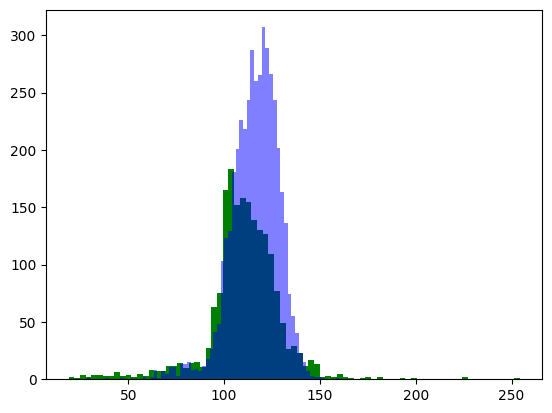

In [63]:
plt.hist(cleaner_collection_plane_df['mean_intensity'], bins='auto', color='green')
plt.hist(pcleaner_collection_plane_df['mean_intensity'], bins='auto', color='blue', alpha=0.5)
plt.show()


In [ ]:
dclusters = cleaner_collection_plane_df['image_intensity'].values
pclusters = pcleaner_collection_plane_df['image_intensity'].values

ddE = []; pdE = []
drr = []; prr = []
dlen = []; plen = []

for cluster in dclusters:
    sumADC = np.sum(cluster, axis=1)
    residual_range = list(range(len(sumADC)-1, -1, -1))
    
    ddE.append(sumADC)
    drr.append(residual_range)
    dlen.append(len(sumADC))

for cluster in pclusters:
    sumADC = np.sum(cluster, axis=1)
    residual_range = list(range(len(sumADC)-1, -1, -1))
    
    pdE.append(sumADC)
    prr.append(residual_range)
    plen.append(len(sumADC))

In [65]:
len(drr), len(ddE), len(prr), len(pdE)

(1910, 1910, 4330, 4330)

In [ ]:
drr = np.concatenate(drr)
ddE = np.concatenate(ddE)
d = np.column_stack((drr, ddE))

prr = np.concatenate(prr)
pdE = np.concatenate(pdE)
p = np.column_stack((prr, pdE))

d = d[d[:, 1] != 0]
p = p[p[:, 1] != 0]

In [67]:
# d[:, 1] = (d[:, 1] - np.min(d[:, 1])) / (np.max(d[:, 1]) - np.min(d[:, 1]))
# p[:, 1] = (p[:, 1] - np.min(p[:, 1])) / (np.max(p[:, 1]) - np.min(p[:, 1]))

In [68]:
# normalisation based on global min / max

# all_dE = np.concatenate([d[:, 1], p[:, 1]])
# global_min = np.min(all_dE)
# global_max = np.max(all_dE)

# d[:, 1] = (d[:, 1] - global_min) / (global_max - global_min)
# p[:, 1] = (p[:, 1] - global_min) / (global_max - global_min)

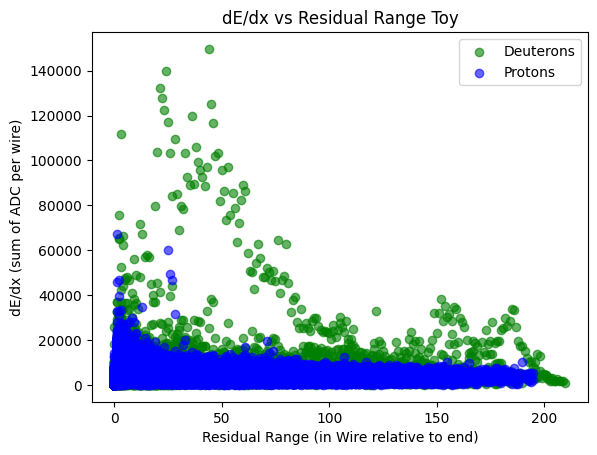

In [69]:
plt.scatter(d[:, 0], d[:, 1], alpha=0.6, label='Deuterons', color='green')
plt.scatter(p[:, 0], p[:, 1], alpha=0.6, label='Protons', color='blue')
plt.xlabel('Residual Range (in Wire relative to end)')
plt.ylabel('dE/dx (sum of ADC per wire)')
plt.title('dE/dx vs Residual Range Toy')
plt.legend()
plt.show()

In [70]:
len(d), len(p)

(141651, 274322)

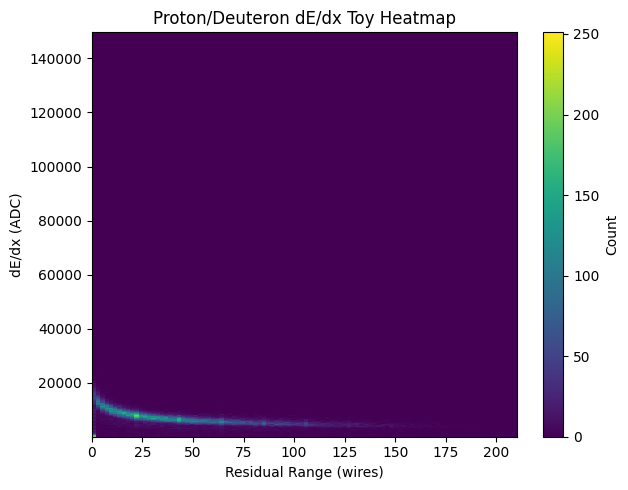

In [71]:
# 2D histogram for both particle types
plt.figure(figsize=(12, 5))

# Combined 2D histogram
plt.subplot(1, 2, 1)
plt.hist2d(np.concatenate([d[:, 0], p[:, 0]]), 
           np.concatenate([d[:, 1], p[:, 1]]), 
           bins=[100, 5000], cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('Residual Range (wires)')
plt.ylabel('dE/dx (ADC)')
plt.title('Proton/Deuteron dE/dx Toy Heatmap')
# plt.ylim(0, 20000)

plt.tight_layout()
plt.show()

# label properly, collection
# hit finder - wire by wire to seperate between two hits, gaussian fit. 
# integrate gaussian fit.
# collection plane.
# z-axis in log

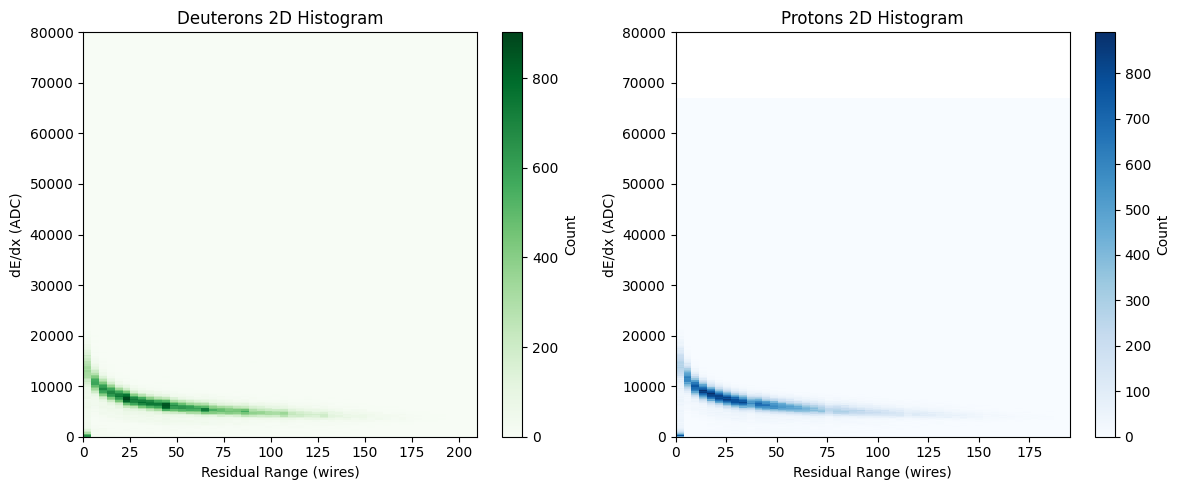

In [72]:
# Separate 2D histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Deuterons
im1 = ax1.hist2d(d[:, 0], d[:, 1], bins=[50, 500], cmap='Greens')
ax1.set_xlabel('Residual Range (wires)')
ax1.set_ylabel('dE/dx (ADC)')
ax1.set_title('Deuterons 2D Histogram')
ax1.set_ylim(0, 80000)
plt.colorbar(im1[3], ax=ax1, label='Count')

# Protons
im2 = ax2.hist2d(p[:, 0], p[:, 1], bins=[50, 500], cmap='Blues')
ax2.set_xlabel('Residual Range (wires)')
ax2.set_ylabel('dE/dx (ADC)')
ax2.set_title('Protons 2D Histogram')
ax2.set_ylim(0, 80000)
plt.colorbar(im2[3], ax=ax2, label='Count')
plt.tight_layout()
plt.show()

# check count
# plotting events
# hunt for events with deuteron + proton, check dE/dx. 

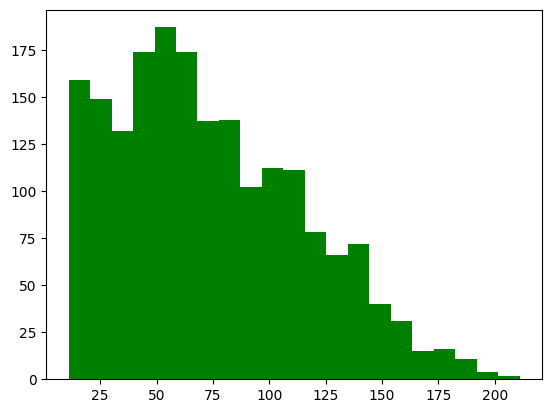

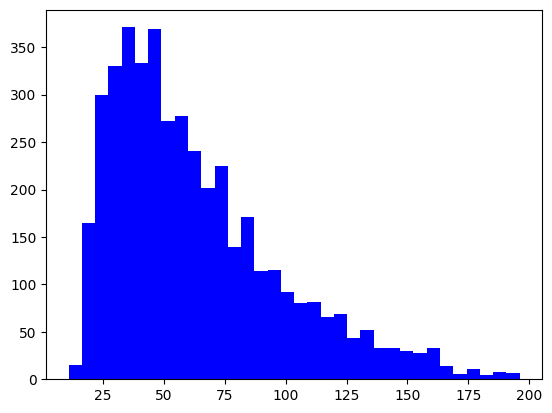

In [73]:
plt.hist(dlen, bins='auto', color='green')
plt.show()
plt.hist(plen, bins='auto', color='blue')
plt.show()

In [74]:
width = np.array(cleaner_collection_plane_df['width'].values)
widx = np.where(width < 20)[0]
len(widx)



3

Plotting 4 events with width < 20...


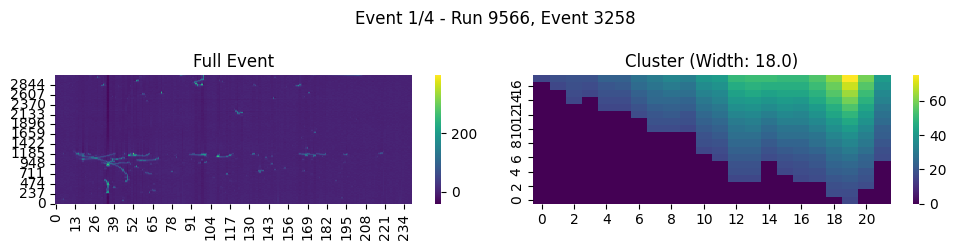

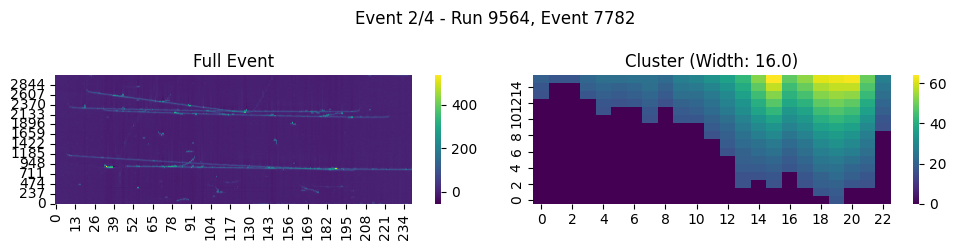

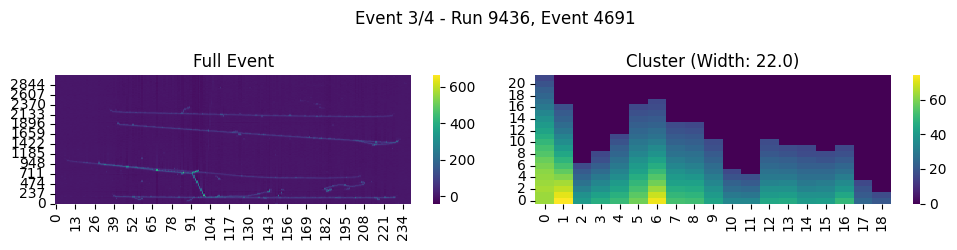

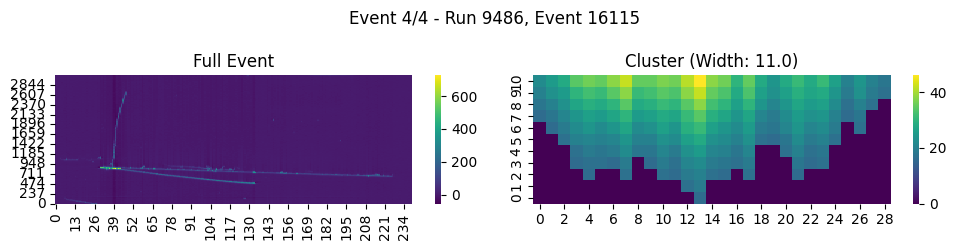

In [75]:
width = np.array(cleaner_collection_plane_df['width'].values)
widx = np.where(width < 30)[0]

print(f"Plotting {len(widx)} events with width < 20...")

# Simple loop through the width indices
for i, idx in enumerate(widx):
    try:
        # Get the event info from cleaner_collection_plane_df
        event_row = cleaner_collection_plane_df.iloc[idx]
        event = Event(event_row['file_path'], plot=False)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
        
        # Full event (always collection plane since we're using cleaner_collection_plane_df)
        sns.heatmap(event.collection.T, cmap="viridis", ax=ax1)
        ax1.invert_yaxis()
        ax1.set_title("Full Event")
        
        # Cluster
        sns.heatmap(event_row['image_intensity'].T, cmap="viridis", ax=ax2)
        ax2.invert_yaxis()
        ax2.set_title(f"Cluster (Width: {event_row['width']:.1f})")
        
        plt.suptitle(f"Event {i+1}/{len(widx)} - Run {event_row['run']}, Event {event_row['event']}")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting event {i+1}: {e}")
        continue